In [2]:
# pip install pandas scikit-learn xgboost joblib matplotlib seaborn


In [7]:
# pip install lightgbm


In [78]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import CategoricalNB
from xgboost import XGBClassifier

# Load and prepare dataset
df = pd.read_csv("dataset.csv", encoding="ISO-8859-1")
df.columns = [re.sub(r"[^\x00-\x7F]+", "", col).strip().lower().replace(" ", "_") for col in df.columns]
df.rename(columns={"free_time_in_one_years_time": "free_time"}, inplace=True)

# Encode categorical features
categorical_cols = ['gender', 'field', 'frequency', 'output', 'impact_learing', 'knowledge', 'dependent', 'restriction']
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

# Encode target
target_le = LabelEncoder()
df['free_time'] = target_le.fit_transform(df['free_time'].astype(str))

X = df[categorical_cols]
y = df['free_time']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
nb = CategoricalNB()
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

voting_clf = VotingClassifier(
    estimators=[('rf', rf), ('lr', lr), ('nb', nb)],
    voting='soft'
)

models = {
    "Random Forest": rf,
    "Logistic Regression": lr,
    "Naive Bayes": nb,
    "XGBoost": xgb,
    "Voting Classifier": voting_clf
}

# Evaluate models
summary = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    summary.append({
        "Model": name,
        "Accuracy": round(accuracy_score(y_test, y_pred), 3),
        "Macro F1": round(f1_score(y_test, y_pred, average='macro'), 3),
        "Weighted F1": round(f1_score(y_test, y_pred, average='weighted'), 3)
    })

summary_df = pd.DataFrame(summary)
print("\n📊 Model Comparison Summary:")
print(summary_df)


C:\Users\ahmed\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:55:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



📊 Model Comparison Summary:
                 Model  Accuracy  Macro F1  Weighted F1
0        Random Forest     0.476     0.411        0.457
1  Logistic Regression     0.488     0.434        0.470
2          Naive Bayes     0.524     0.437        0.488
3              XGBoost     0.451     0.413        0.444
4    Voting Classifier     0.476     0.414        0.454


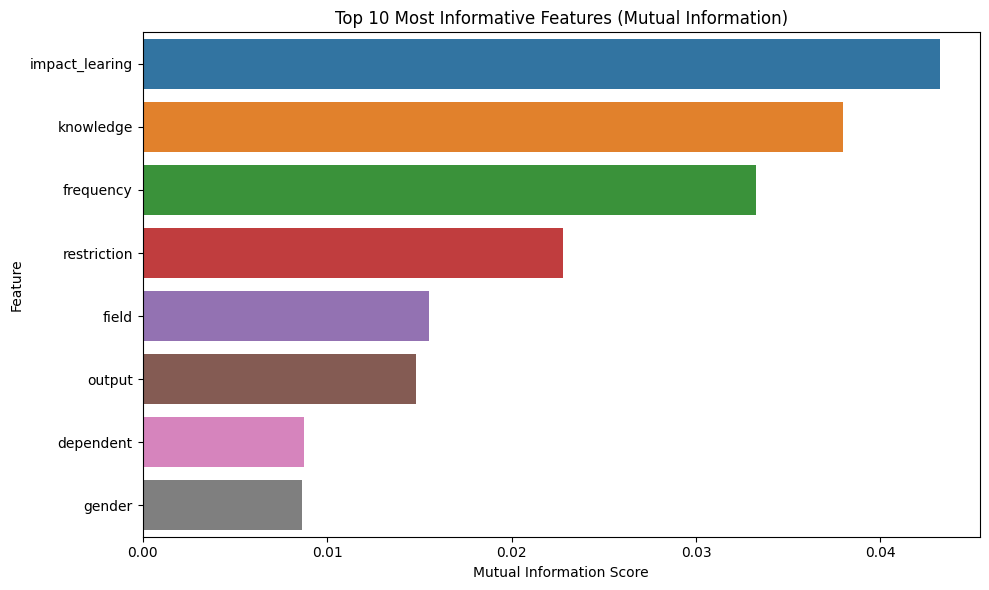

✅ Mutual information scores saved to 'mutual_information_scores.csv'


In [79]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# Load and clean dataset
df = pd.read_csv("dataset.csv", encoding="ISO-8859-1")
df.columns = [re.sub(r"[^\x00-\x7F]+", "", col).strip().lower().replace(" ", "_") for col in df.columns]
df.rename(columns={"free_time_in_one_years_time": "free_time"}, inplace=True)

# Encode categorical input features
categorical_cols = ['gender', 'field', 'frequency', 'output', 'impact_learing', 'knowledge', 'dependent', 'restriction']
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

# Encode target variable
target_le = LabelEncoder()
df['free_time'] = target_le.fit_transform(df['free_time'].astype(str))

# Split data
X = df[categorical_cols]
y = df['free_time']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature selection with mutual information (deterministic)
selector = SelectKBest(
    lambda X, y: mutual_info_classif(X, y, discrete_features=True, random_state=42),
    k='all'
)
selector.fit(X_train, y_train)
mi_scores = pd.Series(selector.scores_, index=X_train.columns).sort_values(ascending=False)

# Plot top 10 features
top_n = 10
plt.figure(figsize=(10, 6))
sns.barplot(x=mi_scores.head(top_n), y=mi_scores.head(top_n).index)
plt.title("Top 10 Most Informative Features (Mutual Information)")
plt.xlabel("Mutual Information Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# Optional: save scores to CSV
mi_scores.to_csv("mutual_information_scores.csv")
print("✅ Mutual information scores saved to 'mutual_information_scores.csv'")


In [81]:
import pandas as pd
import requests
import io
import re
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import CategoricalNB

# Load dataset
url = "https://raw.githubusercontent.com/AhmedUdst/ai_mena/main/dataset.csv"
response = requests.get(url)
df = pd.read_csv(io.StringIO(response.text))

# Clean column names
df.columns = [re.sub(r"[^\x00-\x7F]+", "", col).strip().lower().replace(" ", "_") for col in df.columns]

# Drop 'id' column if present
if 'id' in df.columns:
    df.drop(columns='id', inplace=True)

# Define target and features
target_col = "free_time"
feature_cols = ['gender', 'field', 'impact_learing', 'knowledge', 'dependent', 'restriction', 'frequency', 'output']
df = df[[target_col] + feature_cols].dropna().reset_index(drop=True)

# Encode target
label_encoder = LabelEncoder()
df[target_col] = label_encoder.fit_transform(df[target_col].astype(str))

# Encode features
encoders = {}
for col in feature_cols:
    if df[col].dtype == 'object':
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        encoders[col] = le

X = df[feature_cols]
y = df[target_col]

# Train model
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
nb = CategoricalNB()
voting_clf = VotingClassifier(estimators=[('rf', rf), ('lr', lr), ('nb', nb)], voting='soft')
voting_clf.fit(X, y)

# Save model and encoders
joblib.dump(voting_clf, "voting_model.pkl")
joblib.dump(label_encoder, "label_encoder.pkl")
joblib.dump(encoders, "feature_encoders.pkl")
joblib.dump(feature_cols, "feature_columns.pkl")

print("✅ Saved: voting_model.pkl, label_encoder.pkl, feature_encoders.pkl, feature_columns.pkl")


✅ Saved: voting_model.pkl, label_encoder.pkl, feature_encoders.pkl, feature_columns.pkl
